*가독성을 위해 하이퍼파라미터 탐색 과정을 합쳐놓음. 객관성을 위해 부분 실행 하여 참고바람

# 손글씨 인식 모델 (Keras를 활용한 손글씨 인식 CNN 모델 구현)


---


###동기 및 진행 의도
OCR 기능을 활용한 문서의 전자화가 대중화되어 있다.  
한글과 같은 문자의 활용도가 상대적으로 높지만, 숫자 데이터도 분야에 따라서 주요한 수단으로 활용된다.  
이 프로젝트에서는 손글씨로 작성된 숫자를 인식할 수 있는 인공신경망을 구축함  


---


###문제정의 및 목표  
손글씨 이미지 input을 인식하여 숫자 0~9 사이의 정확한 output 출력하는 인공 신경망 모델 구현  

딥러닝은 데이터들 간의 규칙성을 파악하기 때문에 픽셀 하나하나를 특성으로 가지는 이미지 처리에 강하다.  

딥러닝 중에서도 영상 처리의 가장 기본인 CNN방식 사용하여 문제를 해결하려한다. 
  

---


###데이터 준비와 전처리  
MNIST Dataset  
Keras에서 MNIST 데이터를 불러오는 기능을 제공하므로 이를 이용해 데이터 호출함      
총 70,000개의 손글씨 숫자(0 ~ 9 digits) 이미지로 구성.   
train_labels 모델 트레이닝을 위한 60,000개의 숫자(integer 0 ~ 9) 라벨(label) 이미지,  
test_labels 모델 구현 후 테스팅을 위한 10,000개의 숫자(integer 0~9) 라벨 이미지로 이루어져 있다  

# Base Line 신경망 구축
### 관련 라이브러리 선언

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model 

###MNIST 데이터셋 호출 및 전처리  
MNIST는 28x28픽셀의 흑백 이미지라 데이터 모양을 28x28x1로 잡음  

0~9 integer의 label데이터는 one-hot-encoding 처리함  

In [ ]:
# 데이터셋 호출 및 분류
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))
train_images, test_images = train_images / 255.0, test_images / 255.0

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
# 이미지 전처리. 데이터 모양을 28x28에서 28x28x1로 reshape함
train_images_vec= train_images.reshape((60000,28,28,1))
test_images_vec= test_images.reshape((10000,28,28,1))

In [ ]:
# 라벨 전처리(0~9 integer). 원핫인코딩
# One-hot Encoding 단 하나의 값만 1(true)이고 나머지 값은 모두 0(false)인 데이터 형태 의미. 컴퓨터가 인식하고 학습하기에 용이하게해줌
def one_hot_encoding(labels,demension=10):
  res = np.zeros((len(labels),demension)) 
  for i , label in enumerate(labels): # enumerate로 리스트에 인덱스(i) 부여
    res[i,label] = 1.
  return res

train_labels_vec = one_hot_encoding(train_labels)
test_labels_vec = one_hot_encoding(test_labels)

print(train_labels_vec.shape)
print(test_labels_vec.shape)

(60000, 10)
(10000, 10)


In [ ]:
# 원핫인코딩 처리 전후 비교
print(train_labels[2])
print(train_labels_vec[2])

4
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


### 데이터셋 분할  
트레이닝 데이터셋 50,000개  
검증 데이터셋 10,000개  
테스트 데이터셋 10,000개  

In [ ]:
rand_indices = np.random.permutation(60000)
valid_indices = rand_indices[50000:60000]
train_indices = rand_indices[0:50000]

train_images_valid = train_images_vec[valid_indices, :, :, :]  # validation data는 중간 트레이닝 검증 목적으로 overfitting 방지 효과있음
train_labels_valid = train_labels_vec[valid_indices, :]

train_images_vec = train_images_vec[train_indices, :, :, :] 
train_labels_vec = train_labels_vec[train_indices, :]

print(train_images_valid.shape) 
print(train_labels_valid.shape) # validation data = 10000
print(train_images_vec.shape)
print(train_labels_vec.shape) # training data = 50000

(10000, 28, 28, 1)
(10000, 10)
(50000, 28, 28, 1)
(50000, 10)


###Base Line 모델 

간단히 층 두개를 이을 모델이므로 Sequential 모델로 층층이 쌓음   

Baseline으로 사용할 모델이라 가장 일반적인 형태로 구축하였음  
'Conv2d'로 Feature Map을 생성하고, 'MaxPooling'으로 차원을 감소시킨 후   
마지막으로 Dense Layer를 사용하여 감소된 차원의 Feature Map들만 Input으로 하여 Output과 완전연결 계층을 생성하여,  
효율적인 학습이 이루어지도록 하였음  

다중분류이므로 softmax를 사용하여  예측값을 확률값으로 변환하고  
이외 활성화함수는 ReLU로 통일함 

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(filters= 10, kernel_size=(5,5), activation='relu', input_shape=(28, 28, 1))) 
model.add(layers.MaxPooling2D((2, 2))) # MaxPooling2D클래스
model.add(layers.Conv2D(filters= 20, kernel_size=(5,5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax')) # softmax 함수는 출력값의 합이 항상 1이며, 각 클래스가 정답일 확률나타냄

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 10)        260       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 10)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 20)          5020      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 20)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 320)               0         
                                                                 
 dense (Dense)               (None, 64)                2

Base Line 신경망 네트워크 시각화

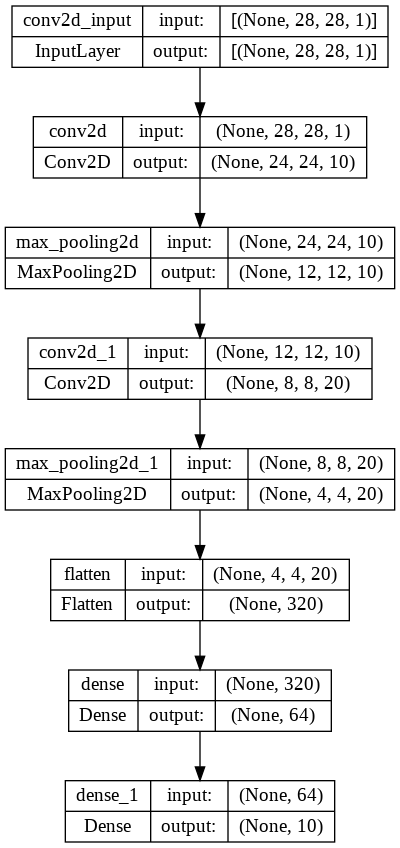

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True)

###Hyperparameter 설정 및 컴파일  
컴파일 과정으로 모델의 손실함수를 정의하고, 정한 손실함수로 얻은 손실값을 통해 모델의 파라미터를 조정하는 옵티마이저 등을 정의함  

기초적인 하이퍼파라미터를 배치하여 나온 결과를 Baseline으로 사용하여 최적의 결과를 찾아보려 함   **굵은 텍스트**
(하이퍼파라미터 조정 과정에서 
metrics는 평가 지표이므로 고정함)  

Optimizer - SGD  
Loss Function - categorical_crossentropy  
Epochs - 10  
Batch size - 32  
Metrics - accuracy  

In [ ]:
model.compile(optimizer=  'SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy']) 
history = model.fit(train_images_valid, train_labels_valid, batch_size=32, epochs=10)

In [ ]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.xlabel('epoch')
plt.legend()

###Base Line 모델 검증 및 평가

In [ ]:
model.evaluate(train_images_valid, train_labels_valid)

In [ ]:
model.evaluate(test_images, test_labels)

In [ ]:
print()
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.xlabel('epoch')
plt.legend()

Baseline 신경망 모델을 학습한 결과, 약 96% 정확도로 성장 여지가 많은 결과가 도출됨  

Epoch 간 accuracy 증가 폭이 작지 않고 일정 수준까지 수렴 속도도 빠르지 않은 것으로 판단하여, Epoch와 Bachsize 증가 필요성을 느낌  

위 2가지 조건을 우선적으로 탐색 후 나머지  Hyperparameter 비교해보고자 함  

###Hyper-parameyer 업데이트  
####Epochs 변경  

epochs=30

In [ ]:
model.compile(optimizer=  'SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy']) 
history = model.fit(train_images_valid, train_labels_valid, batch_size=32, epochs=30)

In [ ]:
model.evaluate(train_images_valid, train_labels_valid)

In [ ]:
model.evaluate(test_images, test_labels)

In [ ]:
print("epochs=30")
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.xlabel('epoch')
plt.legend()

epochs=50

In [ ]:
model.compile(optimizer=  'SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy']) 
history = model.fit(train_images_valid, train_labels_valid, batch_size=32, epochs=30)

In [ ]:
model.evaluate(train_images_valid, train_labels_valid)

In [ ]:
model.evaluate(test_images, test_labels)

In [ ]:
print("epochs=50")
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.xlabel('epoch')
plt.legend()

베이스라인의 조건에서 에포크만 상향 조정했을 때, 모두 정확도가 상승함   
표를 보면 에포크 50 전후부터 Overfiitting 현상 발견되고  
설정이 30일 때와 50일 때의 뚜렷한 결과 차이가 없기에, 이후 에포크는 30으로 설정함

####Bach size 변경  

Bach size=64

In [ ]:
model.compile(optimizer=  'SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy']) 
history = model.fit(train_images_valid, train_labels_valid, batch_size=64, epochs=30)

In [ ]:
model.evaluate(train_images_valid, train_labels_valid)

In [ ]:
model.evaluate(test_images, test_labels)

In [ ]:
print("batch_size=64")
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.xlabel('epoch')
plt.legend()

Bach size=128

In [ ]:
model.compile(optimizer=  'SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy']) 
history = model.fit(train_images_valid, train_labels_valid, batch_size=128, epochs=30)

In [ ]:
model.evaluate(train_images_valid, train_labels_valid)

In [ ]:
model.evaluate(test_images, test_labels)

In [ ]:
print("batch_size=128")
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.xlabel('epoch')
plt.legend()

배치사이즈 증가 결과, 모두 급격한 정확도 하락 관찰됨  
조정을 통한 학습 속도, 일정 수준 Accuracy까지 수렴 속도 모두 체감되지 않음  
이후 Bachsize는 32로 고정함  

####Optimizer 변경 

Adam


In [ ]:
model.compile(optimizer=  'adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']) 
history = model.fit(train_images_valid, train_labels_valid, batch_size=32, epochs=30)

In [ ]:
model.evaluate(train_images_valid, train_labels_valid)

In [ ]:
model.evaluate(test_images, test_labels)

In [ ]:
print("adam")
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.xlabel('epoch')
plt.legend()

RMS Prop

In [ ]:
from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer=  RMSprop,
              loss='categorical_crossentropy',
              metrics=['accuracy']) 
history = model.fit(train_images_valid, train_labels_valid, batch_size=32, epochs=30)

In [ ]:
model.evaluate(train_images_valid, train_labels_valid)

In [ ]:
model.evaluate(test_images, test_labels)

In [ ]:
print("RMS prop")
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.xlabel('epoch')
plt.legend()

SGD, Adam 사용에서 높은 Accuracy를 확인할 수 있다  
Adam이 가장 loss 시작점이 낮고 최솟값으로 빠르게 수렴하여 가장 적합하다고 판단됨  
계산 비용을 고려하면SGD 옵티마이저의 의 효율이 좋다

####Loss function  
binary_crossentropy

In [ ]:
model.compile(optimizer=  'adam',
              loss='binary_crossentropy',
              metrics=['accuracy']) 
history = model.fit(train_images_valid, train_labels_valid, batch_size=32, epochs=30)

In [ ]:
model.evaluate(train_images_valid, train_labels_valid)

In [ ]:
model.evaluate(test_images, test_labels)

In [ ]:
print("binary_crossentropy")
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.xlabel('epoch')
plt.legend()

MSE

In [ ]:
model.compile(optimizer=  'adam',
              loss='MSE',
              metrics=['accuracy']) 
history = model.fit(train_images_valid, train_labels_valid, batch_size=32, epochs=30)

In [ ]:
model.evaluate(train_images_valid, train_labels_valid)

In [ ]:
model.evaluate(test_images, test_labels)

In [ ]:
print("MSE")
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.xlabel('epoch')
plt.legend()

categorical_crossentropy가 다중분류에서 대표적이고 softmax와 짝으로 사용되기에 좋은 결과가 나올줄 알았는데 Accuracy차이가 없음  
Epochs, batchsize를 줄여보아도 가시적인 결과가 나오지 않아 이 데이터셋에서 영향력이 작은 것으로 보임  
데이터셋 변경, Optimizer과 연관성 확인 등 추가적인 검증 필요하다고 보여짐

###프로젝트 분석

Hyperparameter를 하나씩 비교해 봄으로써 각 인자의 기작과 데이터셋과의 
연결에 대해 생각해보고 결과에 미치는 영향력을 확인할 수 있었음  

batch size를 낮게 설정하면 시간이 오래걸림   
(한 번에 많은 데이터 학습 시간< 조금씩 자주 학습 시간)  
 
적은 데이터량과 한정적인 조건에서 실행하여 신뢰하기 힘들다고 판단됨  
결과가 예상과 다르거나 다른 파라미터와 뚜렷한 차이가 없는 경우가 많았음  

인자 하나만을 비교하여 인자 간의 연관 관계 파악이 어려움  

모델 구조, DropOut, Callback 등 더 적용할 수 있는 인자에 대해 검증 필요성 느낌  